## Fourier Modes, Bar Formation, Gas Flows

The purpose of this notebook is to investigate why some simulations seem to form bars and others don't. The primary method of seeing how "barry" a simulation is will be through the investigation of Fourier modes, which are simple to calculate and seem to be relatively stable. The question is - is the formation or non-formation of the bar related to how much radial gas flow happens to occur at the early stages of the bar forming?

In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm
import astropy.units as u
from numba import njit
import h5py as h5
import time

In [3]:
sim_list = ['fRpoly-Rcore1.0', 'fRpoly2-Rcore1.0', 'Nbody']

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

### Center of Mass

First I want to look and see just how much the center of mass of the system shifts throughout the course of the sim. To do this, I will compute the center of mass using a standard iterative technique for sim 0.

In [60]:
def find_com(snap, Rinit=20, Rmin=0.2, Rfac=0.8, components=[0, 1, 2, 3, 4], com_init=np.array([200, 200, 200])):
    pos = np.array([]).reshape(0, 3)
    mass = np.array([])
    
    for i in components:
        if snap.NumPart_Total[i] > 0:
            part = getattr(snap, 'part'+str(i))
            pos = np.concatenate((pos, part.pos))
            if snap.MassTable[i] > 0:
                mass = np.concatenate((mass, np.full(snap.NumPart_Total[i], snap.MassTable[i])))
            else:
                mass = np.concatenate((mass, part.mass))
    
    Rtest = Rinit
    com = com_init
    while Rtest > Rmin:
        pos_minus_com = np.subtract(pos, com)
        key = np.where(np.linalg.norm(pos_minus_com, axis=1) < Rtest)[0]
        com = np.average(pos[key], weights=mass[key], axis=0)
        Rtest *= Rfac
    
    return com
    

In [59]:
%%time
snap = read_snap(0, 0, parttype=[0, 1, 2, 3, 4, 5], fields=['Coordinates', 'Masses'])

CPU times: user 350 ms, sys: 302 ms, total: 652 ms
Wall time: 664 ms


In [65]:
%%time
com = find_com(snap)

CPU times: user 19.6 s, sys: 10.1 s, total: 29.7 s
Wall time: 29.8 s


In [62]:
tlist = []
com_list = []
for i in tqdm(np.arange(0, 200, 10)):
    snap = read_snap(i, 0, parttype=[0, 1, 2, 3, 4, 5], fields=['Coordinates', 'Masses'])
    com = find_com(snap)
    
    tlist.append(snap.Time)
    com_list.append(com)

tlist = np.array(tlist)
com_list = np.array(com_list)



  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:30<09:31, 30.08s/it]

 10%|█         | 2/20 [01:05<09:28, 31.58s/it]

 15%|█▌        | 3/20 [01:34<08:47, 31.02s/it]

 20%|██        | 4/20 [02:10<08:36, 32.31s/it]

 25%|██▌       | 5/20 [02:45<08:16, 33.13s/it]

 30%|███       | 6/20 [03:20<07:51, 33.65s/it]

 35%|███▌      | 7/20 [03:54<07:22, 34.00s/it]

 40%|████      | 8/20 [04:29<06:50, 34.18s/it]

 45%|████▌     | 9/20 [05:04<06:18, 34.39s/it]

 50%|█████     | 10/20 [05:39<05:45, 34.55s/it]

 55%|█████▌    | 11/20 [06:17<05:20, 35.66s/it]

 60%|██████    | 12/20 [06:58<04:58, 37.37s/it]

 65%|██████▌   | 13/20 [07:49<04:50, 41.44s/it]

 70%|███████   | 14/20 [08:46<04:35, 45.99s/it]

 75%|███████▌  | 15/20 [09:35<03:55, 47.00s/it]

 80%|████████  | 16/20 [10:31<03:17, 49.49s/it]

 85%|████████▌ | 17/20 [11:28<02:35, 51.75s/it]

 90%|█████████ | 18/20 [12:25<01:47, 53.52s/it]

 95%|█████████▌| 19/20 [13:27<00:55, 55.89s/it]

100%|██████████| 20/20 [14:31<00:00,

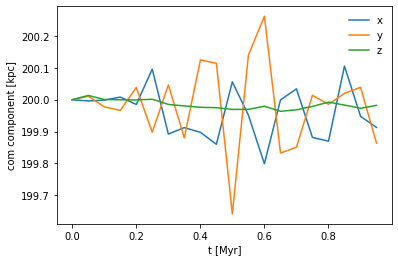

In [63]:
plt.plot(tlist, com_list[:,0], label='x')
plt.plot(tlist, com_list[:,1], label='y')
plt.plot(tlist, com_list[:,2], label='z')

plt.xlabel('t [Myr]')
plt.ylabel('com component [kpc]')
plt.legend(frameon=False)
plt.show()

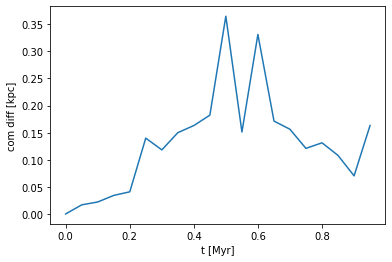

In [64]:
com_diff = com_list - np.array([200, 200, 200])
com_diff_mag = np.linalg.norm(com_diff, axis=1)

plt.plot(tlist, com_diff_mag)

plt.xlabel('t [Myr]')
plt.ylabel('com diff [kpc]')
plt.show()

### Fourier Components
Center of mass seems to be relatively stable. Detailed analysis (to be done later) should take this into account, but for now we can accept a shift of ~300 pc.

Now, we need to compute the fourier component of just the disk component.

In [4]:
basepath = '/n/home01/abeane/starbar/plots/'
sim_list = ['fRpoly-Rcore1.0', 'fRpoly2-Rcore1.0', 'Nbody']

fourier_list = []
gasflow_list = []
for sim in sim_list:
    fourier = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-lvl3.hdf5', mode='r')
    fourier_list.append(fourier)
    
    try:
        gasflow = h5.File(basepath+'/radial_gasflow_rate/data/gasflow_'+sim+'-lvl3.hdf5', mode='r')
        gasflow_list.append(gasflow)
    except:
        gasflow_list.append(None)

In [6]:
def extract_t_A2A0(fourier, idx):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        A2r = fourier[key]['A2r'][idx]
        A2i = fourier[key]['A2i'][idx]
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
        A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_AmA0(fourier, idx, m):

    i = 0

    tlist = np.array(fourier['time'])
    AmA0list = []
#     print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        Amr = fourier[key]['A'+str(m)+'r'][idx]
        Ami = fourier[key]['A'+str(m)+'i'][idx]
    
        Am = np.sqrt(Amr*Amr + Ami*Ami)
        AmA0list.append(Am/A0)
        i += 1
    
    return np.array(tlist), np.array(AmA0list)

def extract_t_gasflow(gasflow, idx):

    i = 0

    tlist = np.array(gasflow['time'])
    flowlist = []
    print(gasflow['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in gasflow.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        flow = gasflow[key]['flow_rate'][idx]
        flowlist.append(flow)
        i += 1
    
    return np.array(tlist), np.array(flowlist)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

2.748652265005497
2.748652265005507
2.748731186845831
2.752628605778281
2.7526286057782037


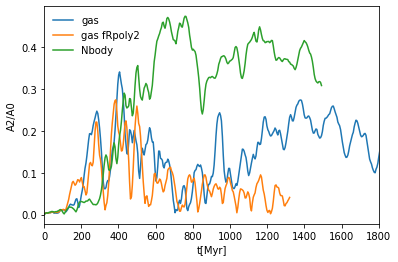

In [23]:
idx = 5

tlist0, A2A0list_0 = extract_t_A2A0(fourier_list[0], idx)
tlist1, A2A0list_1 = extract_t_A2A0(fourier_list[1], idx)
tlist2, A2A0list_2 = extract_t_A2A0(fourier_list[2], idx)
tlist0_gas, flowrate_0 = extract_t_gasflow(gasflow_list[0], idx)
tlist1_gas, flowrate_1 = extract_t_gasflow(gasflow_list[1], idx)

fig, ax = plt.subplots(1, 1)

l0 = ax.plot(tlist0, A2A0list_0, label='gas')
l0 = ax.plot(tlist1, A2A0list_1, label='gas fRpoly2')
ax.plot(tlist2, A2A0list_2, label='Nbody')

# l1 = ax.plot(tlist1, A2A0list_1)

# ax1 = ax.twinx()
# frate_ma = moving_average(flowrate_0, 10)
# tlist0_gas_ma = moving_average(tlist0_gas, 10)
# ax1.plot(tlist0_gas_ma, frate_ma, c='g')
# ax1.plot(tlist0_gas_ma, np.abs(frate_ma), c='g', ls='dashed')
# ax1.plot(tlist1_gas, flowrate_1, c=l1[0].get_color(), ls='dashed')

ax.set(xlabel='t[Myr]', xlim=(0, 1800), ylabel='A2/A0')
ax.legend(frameon=False)
# ax1.set(ylabel='inflow rate', ylim=(0, 0.2))

plt.show()



2.748652265005497
2.748652265005507
2.752628605778281
2.7526286057782037


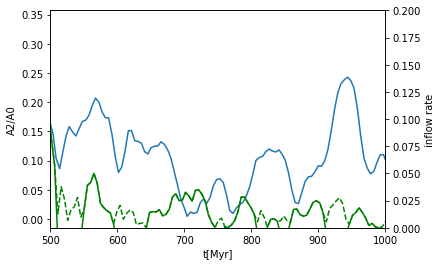

In [24]:
idx = 5

tlist0, A2A0list_0 = extract_t_A2A0(fourier_list[0], idx)
tlist1, A2A0list_1 = extract_t_A2A0(fourier_list[1], idx)
tlist0_gas, flowrate_0 = extract_t_gasflow(gasflow_list[0], idx)
tlist1_gas, flowrate_1 = extract_t_gasflow(gasflow_list[1], idx)

fig, ax = plt.subplots(1, 1)

l0 = ax.plot(tlist0, A2A0list_0)
# l1 = ax.plot(tlist1, A2A0list_1)

ax1 = ax.twinx()
frate_ma = moving_average(flowrate_0, 10)
tlist0_gas_ma = moving_average(tlist0_gas, 10)
ax1.plot(tlist0_gas_ma, frate_ma, c='g')
ax1.plot(tlist0_gas_ma, np.abs(frate_ma), c='g', ls='dashed')
# ax1.plot(tlist1_gas, flowrate_1, c=l1[0].get_color(), ls='dashed')

ax.set(xlabel='t[Myr]', xlim=(500, 1000), ylabel='A2/A0')
ax1.set(ylabel='inflow rate', ylim=(0, 0.2))

plt.show()


2.748652265005497
2.748652265005507
2.752628605778281
2.7526286057782037


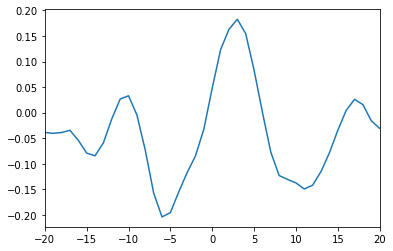

In [28]:
idx = 5

tlist0, A2A0list_0 = extract_t_A2A0(fourier_list[0], idx)
tlist1, A2A0list_1 = extract_t_A2A0(fourier_list[1], idx)
tlist0_gas, flowrate_0 = extract_t_gasflow(gasflow_list[0], idx)
tlist1_gas, flowrate_1 = extract_t_gasflow(gasflow_list[1], idx)

x = A2A0list_0[50:150]
corrcoeff_list = []
for i in np.arange(-50, 50):
    y = flowrate_0[50+i:150+i]
    corrcoeff_list.append(np.corrcoef(x, y)[0][1])
    
plt.plot(np.arange(-50, 50), corrcoeff_list)
plt.xlim(-20, 20)
plt.show()

2.748652265005497
2.748652265005507
2.752628605778281
2.7526286057782037


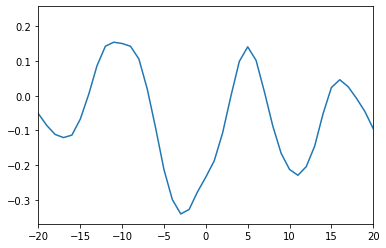

In [18]:
idx = 5

tlist0, A2A0list_0 = extract_t_A2A0(fourier_list[0], idx)
tlist1, A2A0list_1 = extract_t_A2A0(fourier_list[1], idx)
tlist0_gas, flowrate_0 = extract_t_gasflow(gasflow_list[0], idx)
tlist1_gas, flowrate_1 = extract_t_gasflow(gasflow_list[1], idx)

x = A2A0list_1[50:150]
corrcoeff_list = []
for i in np.arange(-50, 50):
    y = flowrate_1[50+i:150+i]
    corrcoeff_list.append(np.corrcoef(x, y)[0][1])
    
plt.plot(np.arange(-50, 50), corrcoeff_list)
plt.xlim(-20, 20)
plt.show()

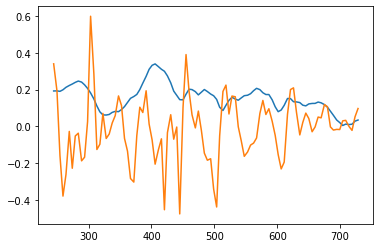

In [21]:
offset = 0
x = tlist0[50:150]
y0 = A2A0list_0[50:150]
y1 = flowrate_1[50+offset:150+offset]

plt.plot(x, y0)
plt.plot(x, y1)
plt.show()

2.748652265005497


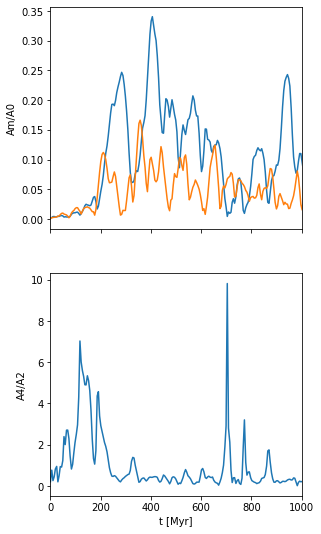

In [19]:
idx = 5

tlist0, A2A0list_0 = extract_t_A2A0(fourier_list[0], idx)
tlist0, A3A0list_0 = extract_t_AmA0(fourier_list[0], idx, 3)
tlist0, A4A0list_0 = extract_t_AmA0(fourier_list[0], idx, 4)
tlist0, A5A0list_0 = extract_t_AmA0(fourier_list[0], idx, 5)
tlist0, A6A0list_0 = extract_t_AmA0(fourier_list[0], idx, 6)
tlist0, A7A0list_0 = extract_t_AmA0(fourier_list[0], idx, 7)
tlist0, A8A0list_0 = extract_t_AmA0(fourier_list[0], idx, 8)
# tlist0, A2A0list_1 = extract_t_A2A0(fourier_list[1], idx)

fig, ax = plt.subplots(2,1, sharex=True, figsize=(4.5, 9))

ax[0].plot(tlist0, A2A0list_0)
ax[0].plot(tlist0, A3A0list_0)
# ax[0].plot(tlist0, A4A0list_0)
# ax[0].plot(tlist0, A6A0list_0)
ax[1].plot(tlist0, A4A0list_0/A2A0list_0)
# l1 = ax.plot(tlist1, A2A0list_1)

ax[0].set(xlim=(0, 1000), ylabel='Am/A0')
ax[1].set(ylabel='A4/A2', xlabel='t [Myr]')

plt.show()



In [ ]:
sn = read_snap()